## SIG-Statistics
Wouter Kouw, 15-06-2018

### Importance-weighting for regression problems with heteroscedasticity.

In this notebook, I will present a regression problem that contains _heteroscedasticity_. [Heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) is defined as different variances for different conditional expectations of Y given X. This might happen when the variance is related to the value of the measurement, for instance when you would like to predict meal expenditure from income, you will see that people with low income spend nearly-constant amounts on food and people with high income spend irregularly on food (example from wikipedia).

I will show some examples on how you combat heteroscedasticty with importance-weighting. 

Note: since the data is randomly generated, some captions will sometimes not accurately describe the figures. If that happens, re-run the notebook.

In [29]:
import numpy as np
import numpy.random as rnd
import scipy.stats as st
import sklearn.linear_model as lm
import sklearn.svm as sv

In [30]:
# Visualization parameters
%matplotlib inline
import matplotlib.pyplot as plt

fig_size = (12,6)
scatter_size = 100
axes_size = 20
plt.rc('font', size=axes_size)
plt.rc('axes', titlesize=axes_size)
plt.rc('axes', labelsize=axes_size)
plt.rc('xtick', labelsize=axes_size)
plt.rc('ytick', labelsize=axes_size)
plt.rc('legend', fontsize=axes_size)
plt.rc('figure', titlesize=axes_size)

In [31]:
# The functions are unknown to you.

def f(x):
    """Regression function."""
    return -(x-1)**2 + 1./2*x + 6

def e(x):
    """Error function."""
    return rnd.randn(*x.shape) * np.exp(-x)

In [32]:
# Sample sizes (N for training, M for testing)
N = 50
M = 50

# Data distribution parameters 
mu_p = 0
si_p = 1

# Generate normally distributed data
px = st.norm(loc=mu_p, scale=si_p)
D = px.rvs(N + M).reshape((-1,1))

# Sort data
D = np.sort(D, axis=0)

# Generate train split from the first N samples
x = D[:N]

# Generate test split from the last M samples
z = D[N:]

# Compute output
y = f(x) + e(x)
u = f(z) + e(z)

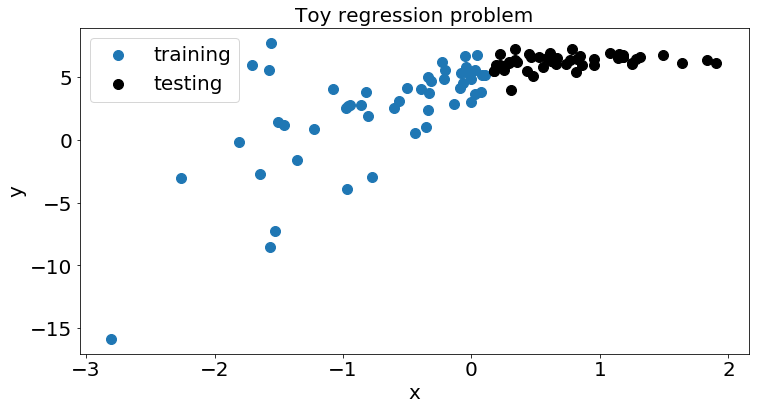

In [33]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(x, y, s=scatter_size, label='training')
ax.scatter(z, u, s=scatter_size, label='testing', color='k')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Toy regression problem');

In the setting above, the data is normally distributed and the regression function is a quadratic polynomial, with an exponentially decreasing error function (heteroscedasticity). The error function makes it hard to recognize the nonlinearity of the problem. Taking an agnostic approach, we start to model the problem using a linear function.

In [34]:
# Fit a linear model and make predictions

# Initialize ridge regression with cross-validation
model1 = lm.RidgeCV(alphas=np.logspace(-4,3,8))

# Fit on given data
model1.fit(x,y)

# Make predictions
y_pred1 = model1.predict(x)
u_pred1 = model1.predict(z)

In [35]:
# Report scores

# Score of unweighted linear model on training data
print('R² on training data: ' + str(model1.score(x, y)))

# Score of unweighted linear model on testing data
print('R² on testing data: ' + str(model1.score(z, u)))

R² on training data: 0.44888946987636436
R² on testing data: -21.609725667445634


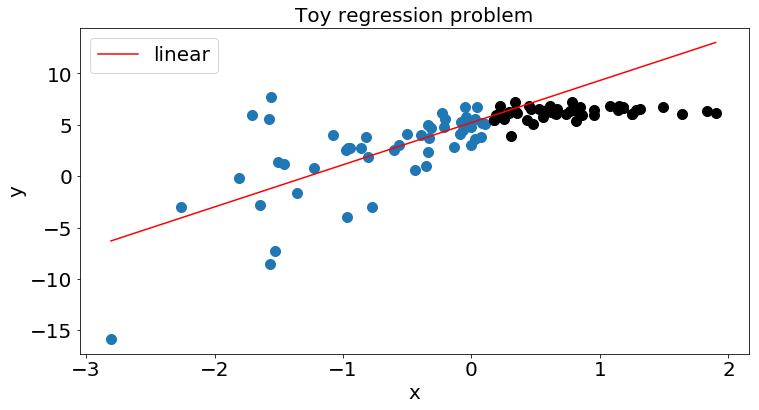

In [36]:
# Visualize predictions

fig, ax = plt.subplots(figsize=fig_size)

# Scatter data
ax.scatter(x, y, s=scatter_size)
ax.scatter(z, u, s=scatter_size, color='k')

# Concatenate predictions for plotting
yu1 = np.vstack((y_pred1, u_pred1))

# Plot regression line
ax.plot(D, yu1, color='r', label='linear')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Toy regression problem');

The figure shows the linear model fitting relatively well to the training data, but not fitting too well on the test data. So, even though we employed regularization, the linear model is overfitting.

###  Uncertainty and importance

Suppose that you know in advance (without looking at the residuals) that the data collected for positive values of $x$ is more accurate than for negative values. You can exploit this information by assigning more importance to those samples. 

In [37]:
# Define importance distribution

# Use normal distribution as importance distribution
qx = st.norm(loc=0, scale=0.5)

In [38]:
# Model input variable distribution

# Estimate data distribution (ph stands for p hat, i.e. the estimated distribution p)
phx = st.norm(loc=np.mean(x), scale=np.var(x))

In [39]:
# Compute importance weights for each sample

def w(x):
    """Importance-weight function."""
    
    # Ratio of importance distribution over data distribution
    wx = qx.pdf(x) / phx.pdf(x)
    
    # Return 1D array
    return wx[:,0]

### Incorporating importance weights in your model

Importance-weights are only used during training. They act as scaling variables on the loss that the model incurs for each sample.

In [40]:
# Fit a new model and make predictions

# Initialize ridge regression with cross-validation
model2 = lm.RidgeCV(alphas=np.logspace(-4,3,8))

# Fit on given data
model2.fit(x,y, sample_weight=w(x))

# Make predictions
y_pred2 = model2.predict(x)
u_pred2 = model2.predict(z)

In [41]:
# Report scores

# Score of weighted linear model on training data
print('R² on training data: ' + str(model2.score(x, y)))

# Score of weighted linear model on training data
print('R² on testing data: ' + str(model2.score(z, u)))

R² on training data: 0.4329583793428874
R² on testing data: -9.861671379989733


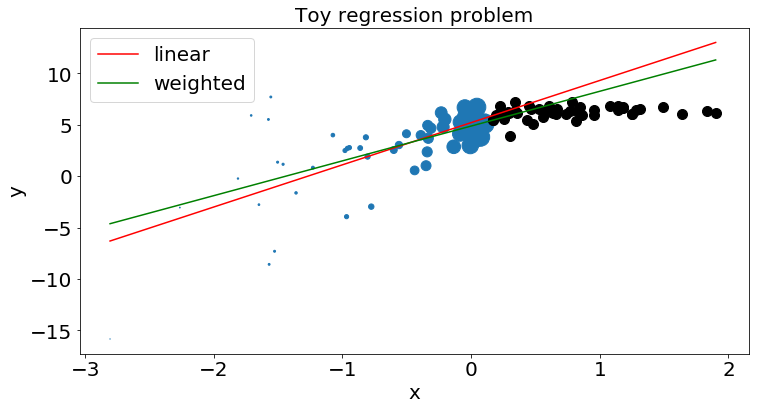

In [42]:
# Visualize predictions

fig, ax = plt.subplots(figsize=fig_size)

# Scatter data
ax.scatter(x, y, s=w(x)*scatter_size)
ax.scatter(z, u, s=scatter_size, color='k')

# Concatenate predictions for plotting
yu2 = np.vstack((y_pred2, u_pred2))

# Plot regression line
ax.plot(D, yu1, color='r', label='linear')

# Plot weighted regression line
ax.plot(D, yu2, color='g', label='weighted')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Toy regression problem');

The weighted regression is told to focus on the rightmost samples and will ignore the leftmost ones. It fits relatively well to the weighted samples, but not so well to the unweighted samples.

Fortunately, since it is less troubled by the large error in the leftmost samples, it will generalize more to the test samples.

## Model misspecification

Importance-weighting is especially powerful when you have misspecified your model; in that case it is relatively "easy" to improve your fit. However, when your model is correctly specified, it is relatively harder to improve your fit.

In [43]:
# Extract quadratic features
from sklearn.preprocessing import PolynomialFeatures as pol
phi_x = pol(degree=2)

# Map training data
x2 = phi_x.fit_transform(x)

# Map test data
z2 = phi_x.fit_transform(z)

In [44]:
# Fit a quadratic non-weighted model 

# Initialize ridge regression with cross-validation
model3 = lm.RidgeCV(alphas=np.logspace(-4,3,8))

# Fit on given data
model3.fit(x2,y)

# Make predictions
y_pred3 = model3.predict(x2)
u_pred3 = model3.predict(z2)

In [45]:
# Compute scores

# Score of unweighted quadratic model on training data
print('R² on training data: ' + str(model3.score(x2, y)))

# Score of unweighted quadratic model on test data
print('R² on training data: ' + str(model3.score(z2, u)))

R² on training data: 0.5016104634310824
R² on training data: -25.227691682957506


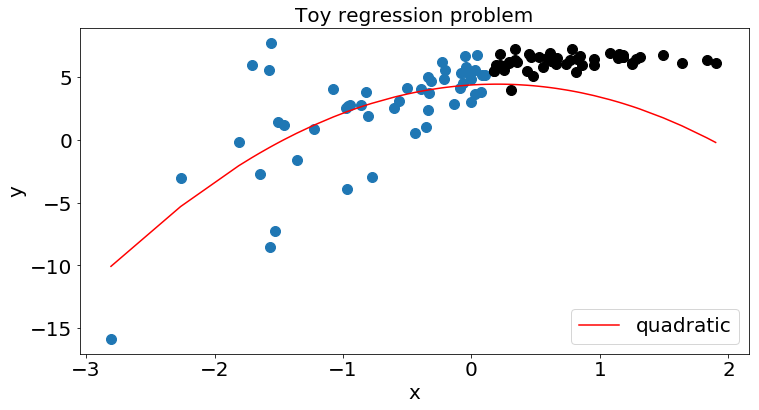

In [46]:
# Visualize predictions

fig, ax = plt.subplots(figsize=fig_size)

# Scatter data
ax.scatter(x, y, s=scatter_size)
ax.scatter(z, u, s=scatter_size, color='k')

# Concatenate predictions for plotting
yu3 = np.vstack((y_pred3, u_pred3))

# Plot regression line
ax.plot(D, yu3, color='r', label='quadratic')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Toy regression problem');

The quadratic model should provide a better fit than the linear model, but might not extrapolate perfectly either.

In [47]:
# Fit a quadratic weighted model 

# Initialize ridge regression with cross-validation
model4 = lm.RidgeCV(alphas=np.logspace(-4,3,8))

# Fit on given data
model4.fit(x2,y, sample_weight=w(x))

# Make predictions
y_pred4 = model4.predict(x2)
u_pred4 = model4.predict(z2)

In [48]:
# Compute scores

# Score of unweighted quadratic model on training data
print('R² on training data: ' + str(model4.score(x2, y)))

# Score of unweighted quadratic model on test data
print('R² on training data: ' + str(model4.score(z2, u)))

R² on training data: 0.4881127209984514
R² on training data: -1.00931971858651


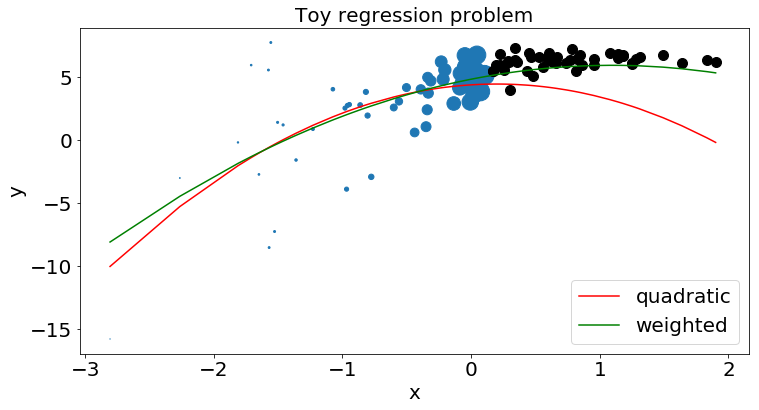

In [49]:
# Visualize predictions

fig, ax = plt.subplots(figsize=fig_size)

# Scatter data
ax.scatter(x, y, s=w(x)*scatter_size)
ax.scatter(z, u, s=scatter_size, color='k')

# Concatenate predictions for plotting
yu4 = np.vstack((y_pred4, u_pred4))

# Plot regression line
ax.plot(D, yu3, color='r', label='quadratic')
ax.plot(D, yu4, color='g', label='weighted')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Toy regression problem');

The weighted model could improve drastically for the test samples, depending on how well the unweighted model fits. 

### Choice of importance distribution

Importance distributions can be chosen manually at the discretion of the researcher / engineer. But there are situations where the shape of the distribution has a more objective origin: 

- In measurement error settings, you could assign importance based on the standard error of your output measure at each input (residuals).
- In extreme value distributions, you can construct an importance distribution based on the modeled rarity of events.
- In sample selection bias settings, where you know that your data is a biased sample with respect to the total population, you can "debias" your data by choosing the inverse data distribution as your importance distribution.
- In active learning settings, you would pick a distribution that maximizes certain metrics on your labeled data distribution, such as representativeness or informativeness.

However, there are 'wrong' choices of importance distributions: if the importance and nominal distributions are too dissimilar, then the variance over the weights increases sharply. As a consequence, the classifier's uncertainty (i.e. sampling variance / variance over datasets) increases. The following example illustrates this situation:

In [50]:
# Choose inappropriate importance distribution

inqx = st.norm(loc=0.25, scale=0.2)

# Compute importance weights for each sample

def inw(x):
    """Importance-weight function."""
    
    # Ratio of importance distribution over data distribution
    wx = inqx.pdf(x) / phx.pdf(x)
    
    # Return 1D array
    return wx[:,0]


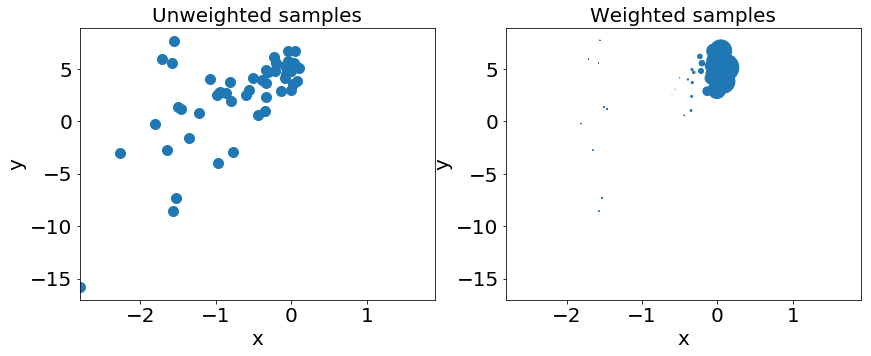

In [51]:
# Scatterplot the data

fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

ax[0].scatter(x, y, s=scatter_size, label='training')
ax[0].set_xlim((np.min(x), np.max(z)))
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Unweighted samples');

ax[1].scatter(x, y, s=inw(x)*scatter_size, label='training')
ax[1].set_xlim((np.min(x), np.max(z)))
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Weighted samples');

The problem is that a few samples are assigned a very large weight, while the majority is assigned a very small weight. This effectively reduces the sample size for the model. This occurs particularly when choosing parametric models.

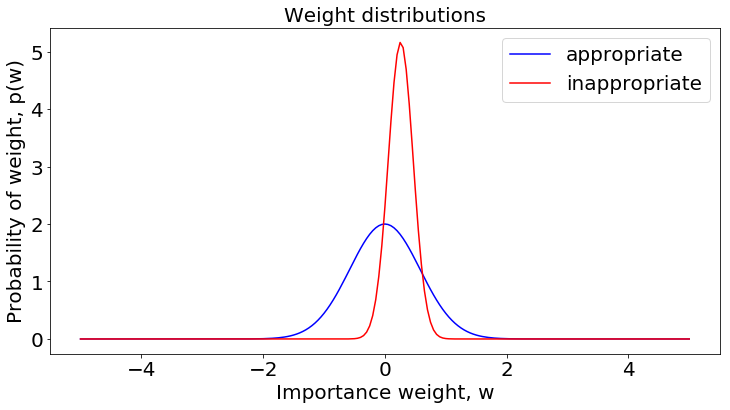

In [52]:
# True importance weight function

def true_wx(x, qx):
    return qx.pdf(x) / px.pdf(x)

fig, ax = plt.subplots(figsize=fig_size)

uu = np.linspace(-5,5,201)

ax.plot(uu, true_wx(uu, qx), color='b', label='appropriate')
ax.plot(uu, true_wx(uu, inqx), color='r', label='inappropriate')

ax.legend()
ax.set_xlabel('Importance weight, w')
ax.set_ylabel('Probability of weight, p(w)')
ax.set_title('Weight distributions');

### References

- My main reference for importance-weighting is Chapter 9 in the textbook "[Sampling](https://statweb.stanford.edu/~owen/mc/)" by Art Owen. 
It's available for [free](https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf).
- The [wikipedia article](https://en.wikipedia.org/wiki/Heteroscedasticity) for heteroscedasticity has more background information and examples.
- The [wikipedia article](https://en.wikipedia.org/wiki/Least_squares) for least-squares has an interesting section on weighted least-squares as well.